In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Model


### Definición de métricas

In [2]:
# Definir la métrica SSIM
def ssim_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    ssim_value = tf.map_fn(lambda x: tf.image.ssim(x[0], x[1], max_val=1.0), (y_true, y_pred), dtype=tf.float32)
    return tf.reduce_mean(ssim_value)

# Definir la métrica PSNR
def psnr_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    psnr_value = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(psnr_value)

## Cargue de imágenes

In [3]:

# Ruta de los archivos DICOM
path_files = '/Users/charlesdaza/Downloads/IDA/PPMI/3D/1.5 Tesla/Sagital'
files_dcm = []

# Recorrer todas las carpetas y subcarpetas
for root, dirs, files in os.walk(path_files):
    images_dcm = [os.path.join(root, file) for file in files if file.endswith('.dcm')]
    images_dcm.sort(key=lambda x: int(pydicom.dcmread(x).InstanceNumber))
    files_dcm.extend(images_dcm)

# Comprobar la cantidad de archivos DICOM encontrados
print(f"Total de archivos DICOM encontrados: {len(files_dcm)}")

# Cargar imágenes que son exactamente de 256x256
images_mri = []
for archivo in files_dcm:
    img = pydicom.dcmread(archivo).pixel_array
    if img.shape == (256, 256):
        images_mri.append(img.astype(np.float32) / 255.0)  # Normalizar a [0, 1]

print(f"Total de imágenes de 256x256 encontradas: {len(images_mri)}")

if images_mri:
    high_img_mri = np.stack(images_mri, axis=0)
    print(f"Forma del volumen de imágenes: {high_img_mri.shape}")
else:
    print("No se encontraron imágenes de 256x256.")

Total de archivos DICOM encontrados: 55858
Total de imágenes de 256x256 encontradas: 31474
Forma del volumen de imágenes: (31474, 256, 256)


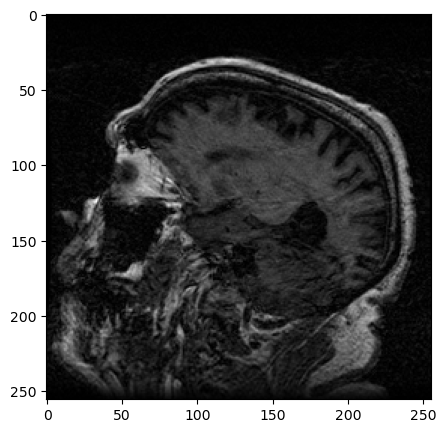

In [4]:
# Ver imágenes de resonancia magnética
plt.figure(figsize=(5, 5))
plt.imshow(high_img_mri[90], cmap='gray')

### Subsampleo

Forma de las imágenes de baja resolución: (31474, 256, 256)


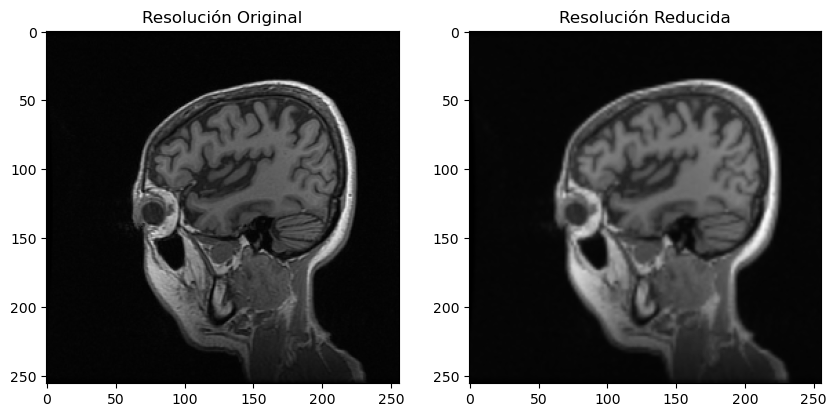

In [5]:
# Reducir resolución
def low_res_image(images, factor):
    low_res_image_result = []
    for image in images:
        if image is None or image.size == 0:
            print("Imagen vacía o no válida, se omite.")
            continue
        image = image.astype(np.float32)  # Asegurarse de que sea float32
        downsampled_size = (int(image.shape[1] * factor), int(image.shape[0] * factor))
        image_downsampled = cv2.resize(image, downsampled_size, interpolation=cv2.INTER_AREA)
        image_upsampled = cv2.resize(image_downsampled, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
        low_res_image_result.append(image_upsampled / 255.0)  # Normalizar a [0, 1]
    return np.stack(low_res_image_result, axis=0) if low_res_image_result else None

factor_res = 0.5

if high_img_mri is not None and high_img_mri.size > 0:
    low_img_mri = low_res_image(high_img_mri, factor_res)
    if low_img_mri is not None:
        print(f"Forma de las imágenes de baja resolución: {low_img_mri.shape}")
    else:
        print("No se generaron imágenes de baja resolución.")
else:
    print("No hay imágenes válidas para procesar.")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(high_img_mri[870], cmap='gray')
plt.title('Resolución Original')
plt.subplot(1, 2, 2)
plt.imshow(low_img_mri[870], cmap='gray')
plt.title('Resolución Reducida')
plt.show()

In [6]:
import numpy as np

SIZE = 256

# Definir porcentajes para división de datos
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Total de imágenes
total_images = len(high_img_mri)

# Calcular índices
train_end = int(total_images * train_ratio)
validation_end = train_end + int(total_images * validation_ratio)

# Preparación de los datos
train_high_mri = high_img_mri[:train_end]
train_low_mri = low_img_mri[:train_end]
validation_high_mri = high_img_mri[train_end:validation_end]
validation_low_mri = low_img_mri[train_end:validation_end]
test_high_mri = high_img_mri[validation_end:]
test_low_mri = low_img_mri[validation_end:]

# Añadir una dimensión
train_high_mri = np.reshape(train_high_mri, (len(train_high_mri), SIZE, SIZE, 1))
train_low_mri = np.reshape(train_low_mri, (len(train_low_mri), SIZE, SIZE, 1))
validation_high_mri = np.reshape(validation_high_mri, (len(validation_high_mri), SIZE, SIZE, 1))
validation_low_mri = np.reshape(validation_low_mri, (len(validation_low_mri), SIZE, SIZE, 1))
test_high_mri = np.reshape(test_high_mri, (len(test_high_mri), SIZE, SIZE, 1))
test_low_mri = np.reshape(test_low_mri, (len(test_low_mri), SIZE, SIZE, 1))

# Imprimir las formas
print("Shape of training mri:", train_high_mri.shape)
print("Shape of validation mri:", validation_high_mri.shape)
print("Shape of test mri:", test_high_mri.shape)


Shape of training mri: (25179, 256, 256, 1)
Shape of validation mri: (3147, 256, 256, 1)
Shape of test mri: (3148, 256, 256, 1)


### Funciones de upsampling y downsampling

In [7]:
# Definir el modelo de downsample
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
        downsample.add(layers.LeakyReLU())
    return downsample
# Definir el modelo de upsample
def up(filters, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    if dropout:
        upsample.add(layers.Dropout(0.2))
        upsample.add(layers.LeakyReLU())
    return upsample 

## Definición del modelo

In [ ]:
# Parámetros del modelo
low_res_image_height, low_res_image_width = 256, 256
channels = 1  # Escala de grises

# Número de iteraciones recursivas
num_recursive_layers = 4

# Definición del modelo DRCN
inputs = layers.Input(shape=(low_res_image_height, low_res_image_width, channels))

# Primera capa convolucional (extracción de características inicial)
feature_extraction = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)

# Capas recursivas
recursive_features = feature_extraction
for _ in range(num_recursive_layers):
    recursive_features = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(recursive_features)

# Reconstrucción (salida final)
output = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(recursive_features)

# Crear el modelo
model = Model(inputs=[inputs], outputs=[output])

# Compilar el modelo con PSNR y SSIM como métricas
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error',
    metrics=[ssim_metric, psnr_metric]  # Puedes agregar ssim_metric y psnr_metric si están definidos
)

# Resumen del modelo
model.summary()



2025-05-23 07:07:15.976750: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-23 07:07:15.976773: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-23 07:07:15.976780: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-23 07:07:15.976796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-23 07:07:15.978387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,929 (581.75 KB)

 Trainable params: 148,929 (581.75 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [9]:
from datetime import datetime
# Ver la hora de inicio del entrenamiento
start_time = datetime.now()
print(f"Entrenamiento comenzó a las: {start_time.strftime('%H:%M:%S')}")

Entrenamiento comenzó a las: 07:07:16


In [10]:
history = model.fit(train_low_mri, train_high_mri, epochs=30, 
                    validation_data=(validation_low_mri, validation_high_mri))


Epoch 1/30


/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


Instructions for updating:
Use fn_output_signature instead


2025-05-23 07:07:34.096666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


787/787 ━━━━━━━━━━━━━━━━━━━━ 411s 520ms/step - loss: 0.2250 - psnr_metric: 21.0235 - ssim_metric: 0.5269 - val_loss: 0.0900 - val_psnr_metric: 27.0680 - val_ssim_metric: 0.7373
Epoch 2/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 407s 516ms/step - loss: 0.0844 - psnr_metric: 26.9409 - ssim_metric: 0.7451 - val_loss: 0.0681 - val_psnr_metric: 29.2013 - val_ssim_metric: 0.8296
Epoch 3/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 407s 517ms/step - loss: 0.0765 - psnr_metric: 27.7379 - ssim_metric: 0.7681 - val_loss: 0.0668 - val_psnr_metric: 29.2206 - val_ssim_metric: 0.7976
Epoch 4/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 408s 518ms/step - loss: 0.0730 - psnr_metric: 28.2746 - ssim_metric: 0.7853 - val_loss: 0.0655 - val_psnr_metric: 29.6520 - val_ssim_metric: 0.8464
Epoch 5/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 408s 518ms/step - loss: 0.0727 - psnr_metric: 28.3031 - ssim_metric: 0.7877 - val_loss: 0.0650 - val_psnr_metric: 29.3395 - val_ssim_metric: 0.8034
Epoch 6/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 410s 521ms/step - loss: 0.0698 

In [11]:
print(history.history.keys())


dict_keys(['loss', 'psnr_metric', 'ssim_metric', 'val_loss', 'val_psnr_metric', 'val_ssim_metric'])


## Evaluación

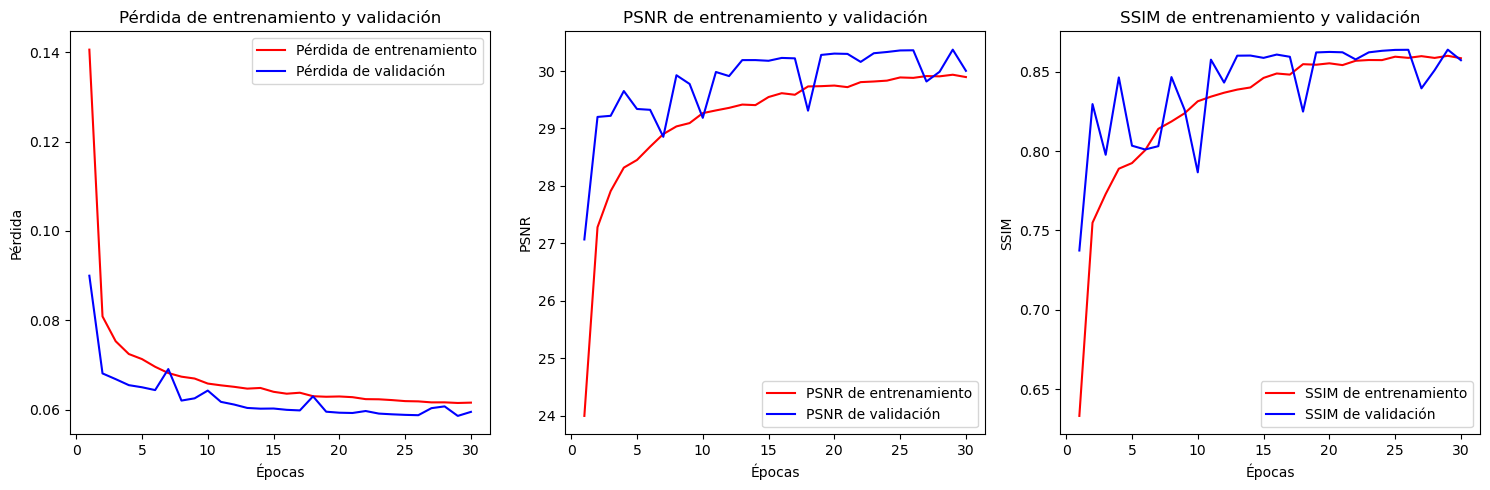

In [12]:

import matplotlib.pyplot as plt

# Obtener las métricas del historial de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
psnr = history.history['psnr_metric']
val_psnr = history.history['val_psnr_metric']
ssim = history.history['ssim_metric']
val_ssim = history.history['val_ssim_metric']

epochs = range(1, len(loss) + 1)

# Crear una figura con 3 subgráficas en una fila
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Graficar la pérdida
axs[0].plot(epochs, loss, 'r', label='Pérdida de entrenamiento')
axs[0].plot(epochs, val_loss, 'b', label='Pérdida de validación')
axs[0].set_title('Pérdida de entrenamiento y validación')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

# Graficar el PSNR
axs[1].plot(epochs, psnr, 'r', label='PSNR de entrenamiento')
axs[1].plot(epochs, val_psnr, 'b', label='PSNR de validación')
axs[1].set_title('PSNR de entrenamiento y validación')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('PSNR')
axs[1].legend()

# Graficar el SSIM
axs[2].plot(epochs, ssim, 'r', label='SSIM de entrenamiento')
axs[2].plot(epochs, val_ssim, 'b', label='SSIM de validación')
axs[2].set_title('SSIM de entrenamiento y validación')
axs[2].set_xlabel('Épocas')
axs[2].set_ylabel('SSIM')
axs[2].legend()

# Ajustar el layout
plt.tight_layout()
plt.show()

In [17]:

# Evaluación en el conjunto de validación
loss, psnr_value, ssim_value = model.evaluate(validation_low_mri, validation_high_mri)
print(f"Loss: {loss}")
print(f"PSNR: {ssim_value}")
print(f"SSIM: {psnr_value}")


99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - loss: 0.0460 - psnr_metric: 30.6435 - ssim_metric: 0.8799
Loss: 0.059497587382793427
PSNR: 30.00385284423828
SSIM: 0.8572179675102234


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


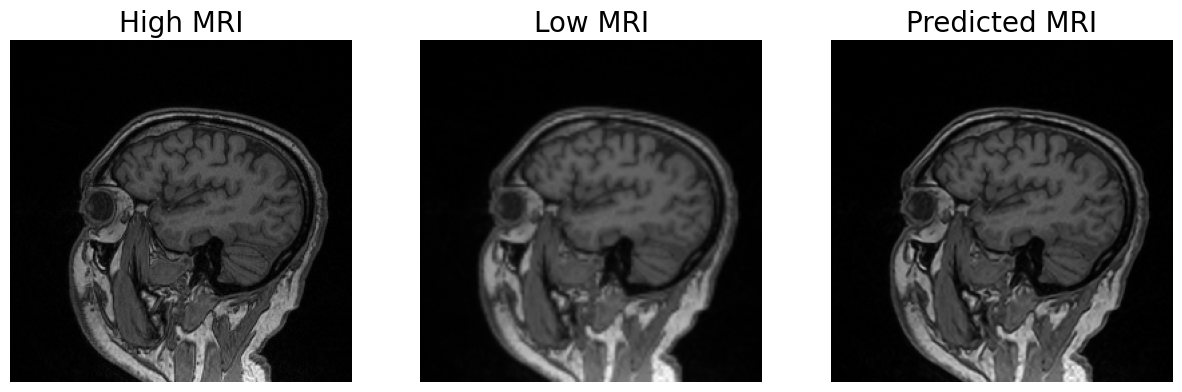

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


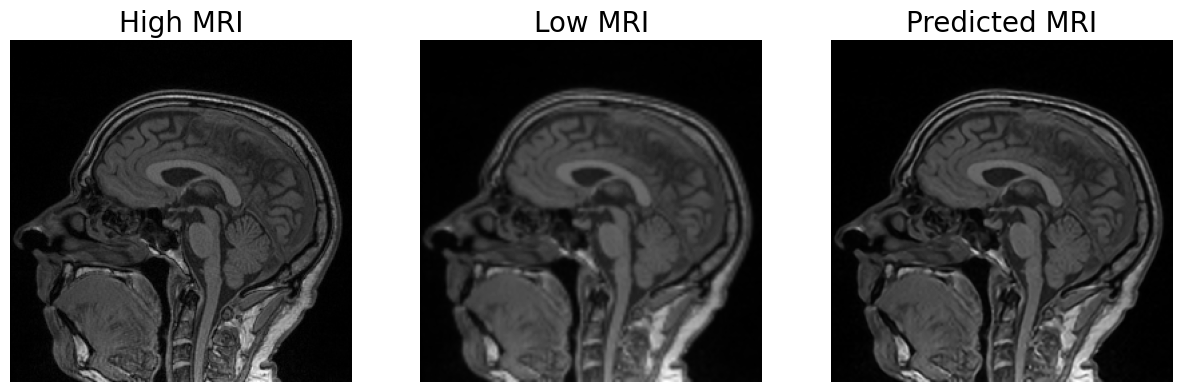

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


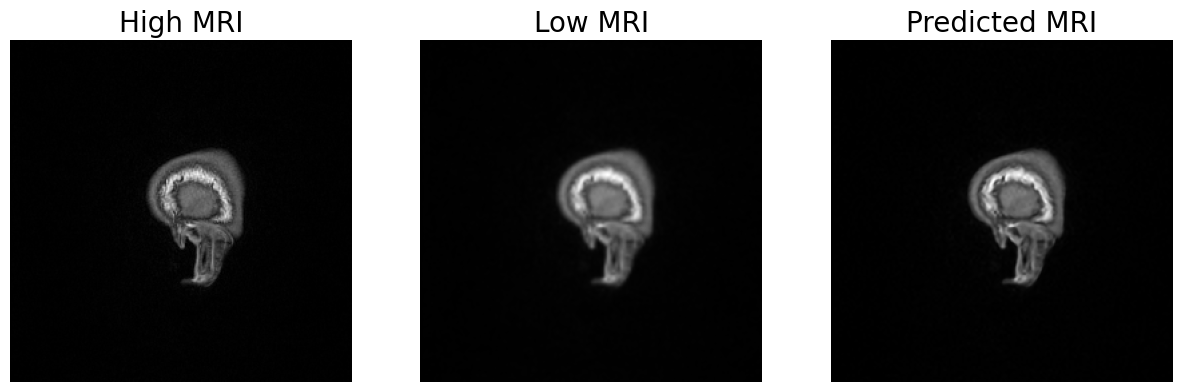

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


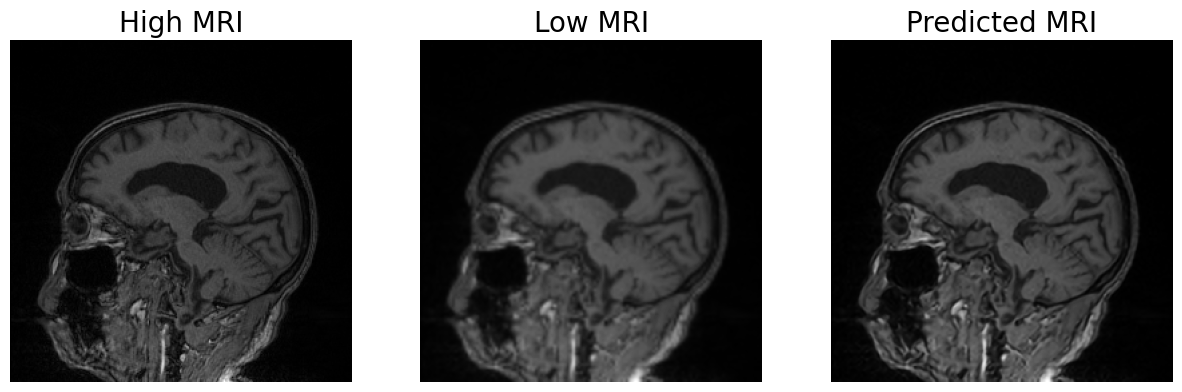

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


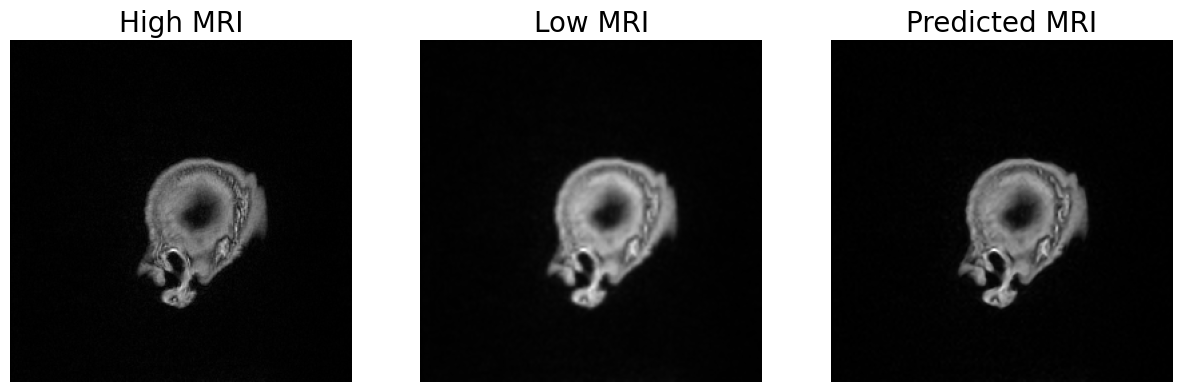

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


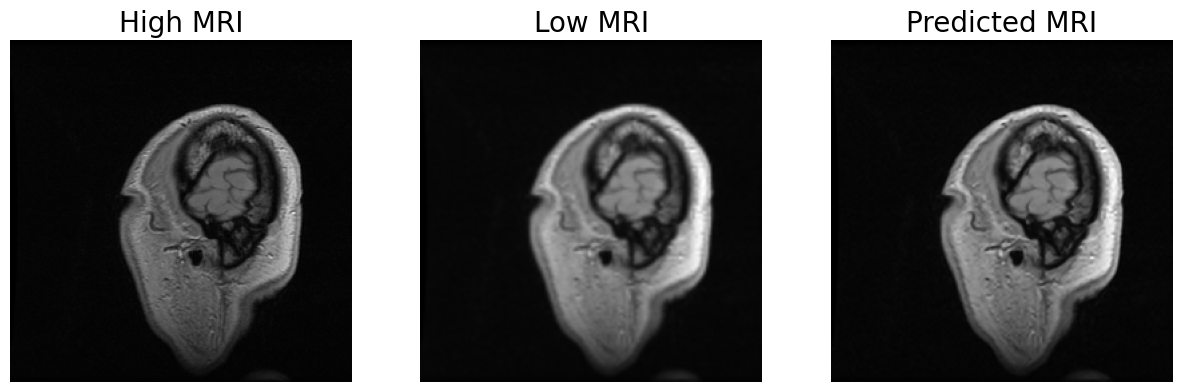

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


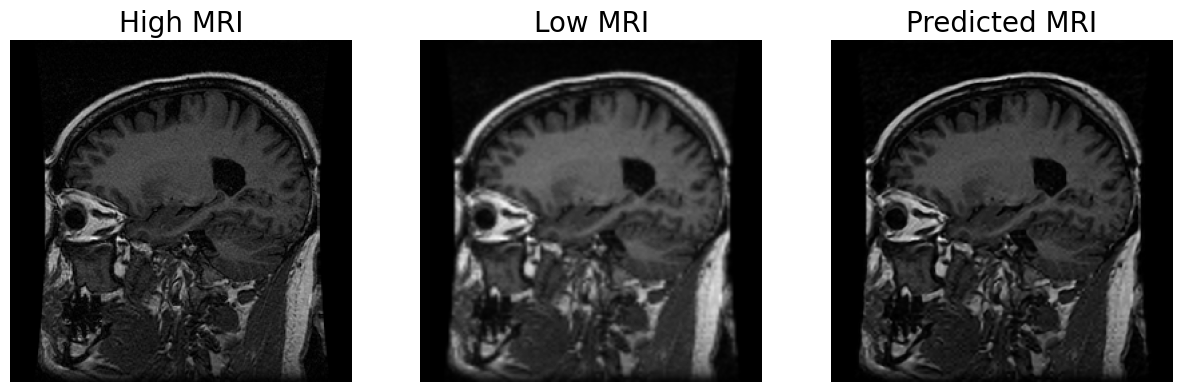

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


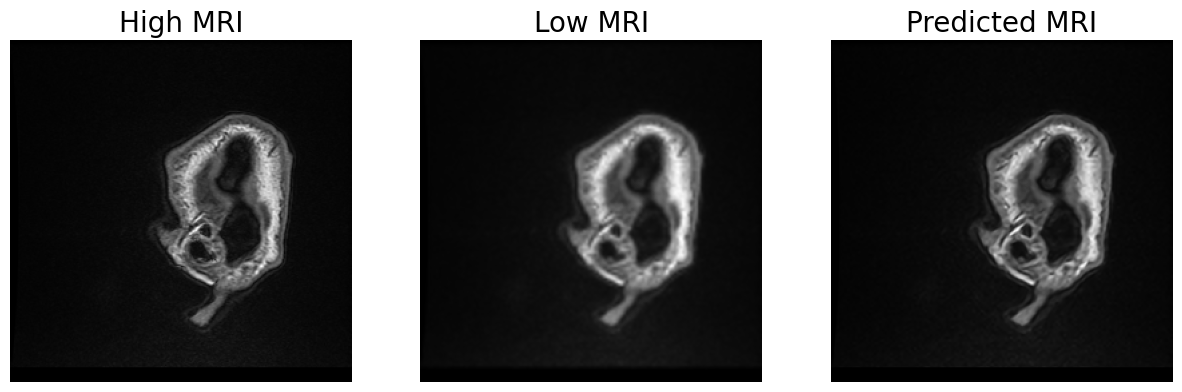

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


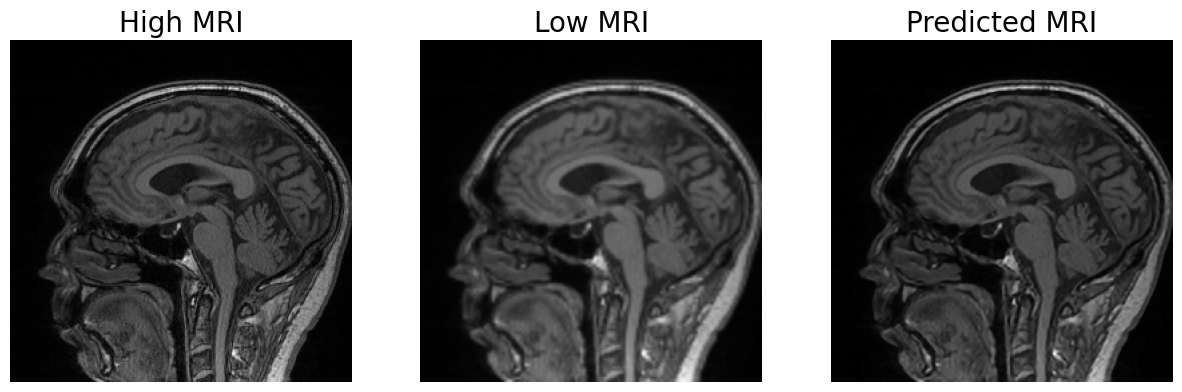

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


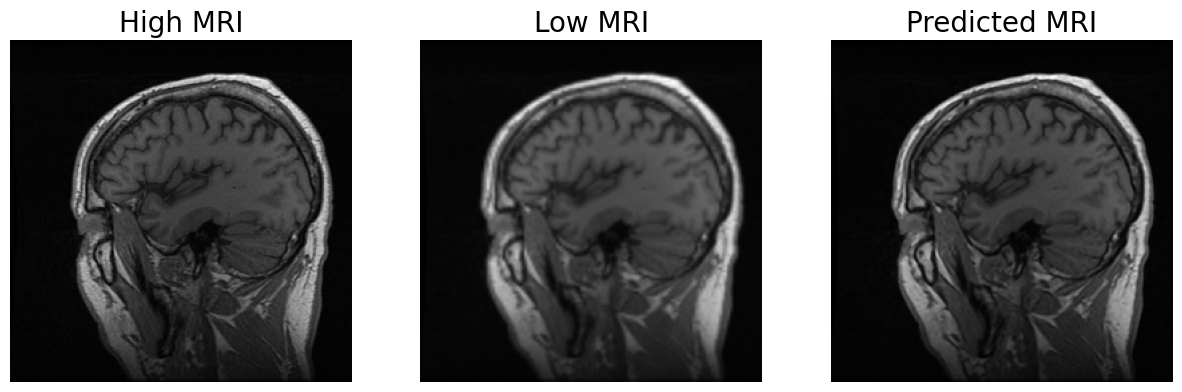

   Número de Imagen     PSNR    SSIM     MSE
0              3017  64.9869  0.9900  0.0206
1              3059  65.1176  0.9864  0.0200
2              2385  73.0024  0.9917  0.0033
3               169  65.5327  0.9878  0.0182
4               227  75.8358  0.9935  0.0017
5              1402  68.5166  0.9967  0.0091
6              2881  82.5271  0.9756  0.0004
7              1118  64.0752  0.9948  0.0254
8               466  63.5617  0.9854  0.0286
9              1420  64.2426  0.9939  0.0245


In [ ]:
import random
# Comparativa imágenes
def psnr(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    diff = ref_data - target_data
    rmse = math.sqrt(np.mean(diff**2.))
    if rmse == 0:
        return float('inf')
    return 20 * math.log10(255. / rmse)

def ssim(target, ref):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    target = target.astype(np.float64)
    ref = ref.astype(np.float64)

    mu1 = np.mean(target)
    mu2 = np.mean(ref)
    sigma1 = np.std(target)
    sigma2 = np.std(ref)
    sigma12 = np.mean((target - mu1) * (ref - mu2))

    ssim_value = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 ** 2 + sigma2 ** 2 + C2))
    return ssim_value

def mae(target, ref):
    return np.mean(np.abs(ref - target))

def mse(target, ref):
  return np.mean((ref.astype(np.float64) - target.astype(np.float64)) ** 2)

def compare_images(target, ref):
    target = np.clip(target, 0, 255)
    ref = np.clip(ref, 0, 255)
    if target.ndim == 3 and target.shape[-1] == 1:
        target = target.squeeze(-1)
    if ref.ndim == 3 and ref.shape[-1] == 1:
        ref = ref.squeeze(-1)
    psnr_score = psnr(target, ref)
    ssim_score = ssim(ref, target)
    mse_score = mse(ref, target)
    return [psnr_score, ssim_score, mse_score]

def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High MRI', color='black', fontsize=20)
    plt.imshow(high, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Low MRI', color='black', fontsize=20)
    plt.imshow(low, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Predicted MRI', color='black', fontsize=20)
    plt.imshow(predicted, cmap='gray')
    plt.axis('off')
    plt.show()

# Lista para almacenar los resultados como diccionarios
results_data = []
indices = list(range(len(test_low_mri)))
random.shuffle(indices)

# Iterar sobre una muestra de índices
for i in indices[:10]:
    # Realizar la predicción
    predicted = model.predict(test_low_mri[i].reshape(1, SIZE, SIZE, 1))
    
    # Procesar la imagen predicha
    pred_img = predicted[0].squeeze()
    pred_img = np.clip(pred_img, 0, 255)
    
    # Comparar imágenes y obtener scores
    score = compare_images(pred_img, test_high_mri[i])
    
    # Almacenar el número de imagen y los scores en un diccionario
    results_data.append({
        'Número de Imagen': i, 
        'PSNR': score[0],
        'SSIM': score[1],
        'MSE': score[2]
    })
    
    # Mostrar imágenes 
    plot_images(test_high_mri[i], test_low_mri[i], pred_img)

# Crear DataFrame de resultados a partir de la lista de diccionarios
df_scores = pd.DataFrame(results_data)

df_scores = df_scores[['Número de Imagen', 'PSNR', 'SSIM', 'MSE']]
df_scores = df_scores.round(4)
# Mostrar el DataFrame
print(df_scores)

### Comparativa imagenes

In [16]:
# Obtener la hora de finalización del entrenamiento
end_time = datetime.now()
print(f"Entrenamiento finalizado a las: {end_time.strftime('%H:%M:%S')}")

# Calcular el tiempo total de entrenamiento
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time}") 

Entrenamiento finalizado a las: 10:30:39
Tiempo total de entrenamiento: 3:23:23.279443
